# New Images Test
This notebook is made to make some test on the new images that we have. We will try to find the best way to preprocess the images and to extract the text from them.

## Imports

In [1]:
import cv2, os, sys, pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import helpers as hlp


## Setup

In [10]:
# imgPath = "images/script-tables/font-border/table_01.jpg"
# imgPath = "images/medium-colors/03.jpg"
# imgPath = "images/scanned/01_r.jpg"
imgPath = "images/easy-noColors/02.jpg"
# imgPath = "images/even-harder-holes-lightColors/02.jpg"
# imgPath = "images/tests-images/02.jpg"
# imgPath = "images/script-tables/rotation-empty-border/table_07.jpg"
# imgPath = "images/script-tables/rotation-\empty-no-border/table_03.jpg"
image = cv2.imread(imgPath)
print(hlp.bcolors.OKGREEN + "# Image loaded\t\t[✔]" + hlp.bcolors.ENDC)

def showimage(img, title):
    if hlp.debug:
        # plt.figure(figsize=(20, 20))
        plt.axis("off")
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.show()

# Image loaded		[✔]


## Rotation
We check if the image seems rotated. If so, we rotate it.

In [3]:
def isImageRotated(img):
    """
    Takes an image as parameter and returns True if it seems rotated, False otherwise.
    """
    im = img.copy()
    # showimage(im, "original")

    blur = cv2.GaussianBlur(im, (7, 7), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 7)
    # showimage(thresh, "thresh")

    kernel = np.ones((21, 1), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # showimage(morph, "morph")

    edges = cv2.Canny(morph, 50, 150, apertureSize=3)
    # showimage(edges, "edges")

    kernel = np.ones((15, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    # showimage(dilated, "dilated")

    lines = cv2.HoughLinesP(dilated, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

    # Get the longest line
    line = lines[0][0]
    for x1, y1, x2, y2 in lines[0]:
        if x2 - x1 > line[2] - line[0]:
            line = [x1, y1, x2, y2]

    # Draw the longest line
    # cv2.line(im, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 2)
    # showimage(im, "lines")

    # Get angle of line
    angle = np.arctan2(line[3] - line[1], line[2] - line[0])
    angle = np.degrees(angle)

    print("Angle of the original image: " + str(int(angle)))

    if not (90 <= abs(angle) < 91 or 0 <= abs(angle) < 1 or 180 <= abs(angle) < 181 or 270 <= abs(angle) < 271):
        hlp.log('Image seems to be rotated')
        return True, angle
    hlp.log('Image seems to be straight')
    return False, angle

def cropToTable(img):
    """
    Takes an image as parameter and returns the image cropped to the table inside (can be not straight).
    Some code from https://stackoverflow.com/questions/59363937/opencv-detecting-an-object-and-its-rotation
    """
    im = img.copy()
    # showimage(im, "original")

    # As usual
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 17, 11)
    # showimage(thresh, "thresh")

    # Find the contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [(cv2.contourArea(cnt), cnt) for cnt in contours]
    areas.sort(key=lambda x: x[0], reverse=True)
    im = cv2.drawContours(im, [areas[0][1]], -1, (0, 255, 0), 1)
    # showimage(im, "contours")

    # Remove the biggest contour (the image)
    areas.pop(0) # Error for rotated script table
    x, y, w, h = cv2.boundingRect(areas[0][1])
    # im = cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Crop the image to the table
    crop = im[y : y + h, x : x + w]

    # showimage(crop, "crop")
    return crop

def rotateImage(img, angle):
    """
        Rotate the image so the table is straight.
    """
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    if angle > 0:
        angle = 270 + angle
    else :
        angle = 90 + angle
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated



# Prespective correction
## TODO : Corriger la perspective si besoin ici

In [4]:
# TODO : Perspective (image : tests-images/02.jpg)
# Find the largest contour (which should be the table)
def perspective(img):
      # As usual
      im = img.copy()
      gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(gray, (7, 7), 0)
      thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 17, 11)
      # showimage(thresh, "thresh")

      # Find the 4 corners of the table
      contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      areas = [(cv2.contourArea(cnt), cnt) for cnt in contours]
      areas.sort(key=lambda x: x[0], reverse=True)
      # im = cv2.drawContours(im, [areas[0][1]], -1, (0, 255, 0), 10)
      # showimage(im, "contours")
      # Get the contour's width and height
      x, y, w, h = cv2.boundingRect(areas[0][1])

      # Correct the perspective to fit the table only in the image
      peri = cv2.arcLength(areas[0][1], True)
      approx = cv2.approxPolyDP(areas[0][1], 0.02 * peri, True)

      # Take largest contour
      pts = np.float32(approx)
      screenpts = np.float32([[0, 0], [0, h], [w, h], [w, 0]])
      
      # Get the perspective matrix with the same ratio
      matrix = cv2.getPerspectiveTransform(pts, screenpts)
      # Apply the perspective transformation
      result = cv2.warpPerspective(im, matrix, (w, h))

      return result

Angle of the original image: -90
Image seems to be straight


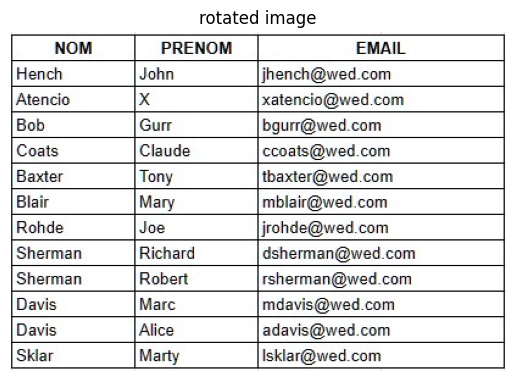

# Image rotated		[✔]


In [12]:
isRotated, angle = isImageRotated(image)
# showimage(image, "original image")
if(isRotated):
    # Rotate the image to have a straight table
    rotated = rotateImage(image, angle)
    # showimage(rotated, "rotated image")

    if(isImageRotated(rotated)[0]):
        rotated = perspective(rotated)
        # showimage(rotated, "rotated image")

else:
    rotated = image

rotated = cropToTable(rotated)
# showimage(rotated, "cropped image")
showimage(rotated, "rotated image")
print(hlp.bcolors.OKGREEN + "# Image rotated\t\t[✔]" + hlp.bcolors.ENDC)


## Remove dark cells
We remove the dark cells from the image. We do this by checking if a cell is dark or not. If it is, we invert it.
Then, we redraw it's contours so that the image is cleaner.

In [8]:
def removeDarkCells(image):
    """
    Remove the cells that have a dark background.
    """
    print("# Cleaning dark cells\t[...]")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove noise
    kernel = np.ones((8, 8), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
    showimage(morph, "morph")

    # Find contours
    contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # Invert the color inside the cells
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        # image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        if w > 10 and h > 10:
            image[y : y + h, x : x + w] = 255 - image[y : y + h, x : x + w]

    showimage(image, "image with dark cells removed")

    hlp.clear()
    print(hlp.bcolors.OKGREEN + "# Dark cells cleaned\t[✔]" + hlp.bcolors.ENDC)

    return image


def redrawContours(img):
    print("# Finding contours\t[...]")
    cntsImg = img.copy()

    # showimage(cntsImg, "contours image")

    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Find contours
    contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contours.pop(0)
    if(len(contours) > 1):
        contours.pop(0)

    # Draw a rectangle around the contours
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w*h > 500: # Filter out small contours
            cv2.rectangle(cntsImg, (x, y), (x+w, y+h), (0, 0, 0), 1)

    showimage(cntsImg, "contours image")

    hlp.clear()
    print(hlp.bcolors.OKGREEN + "# Contours found\t[✔]" + hlp.bcolors.ENDC)

    return cntsImg, thresh

# Cleaning dark cells	[...]


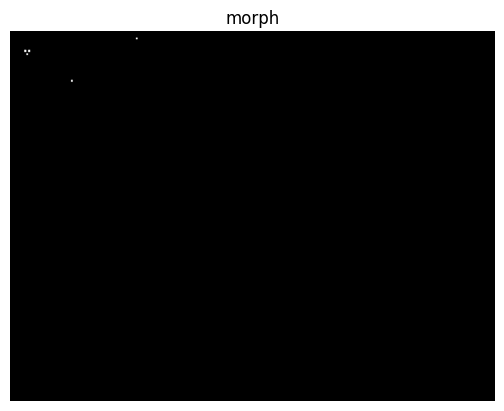

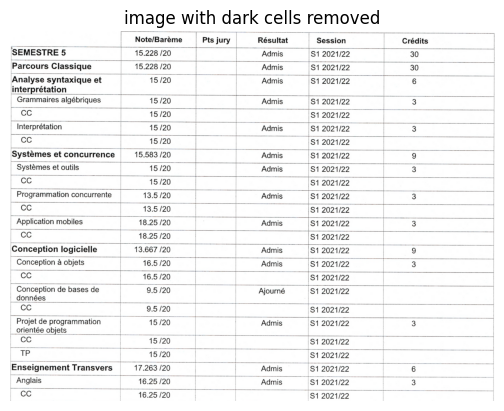

# Dark cells cleaned	[✔]
# Finding contours	[...]


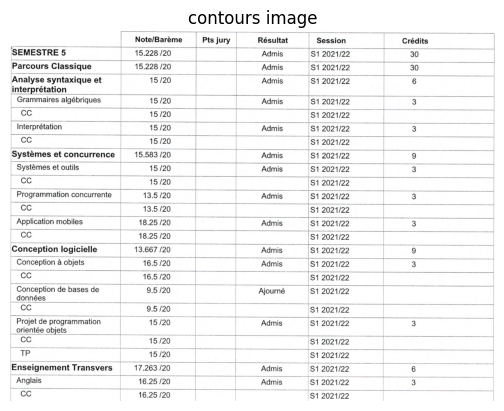

# Contours found	[✔]


In [9]:
im = removeDarkCells(rotated.copy())

# If image is mostly black, invert it
if np.mean(im) < 127:
    im = 255 - im

cntsImg, thresh = redrawContours(im)

## Preprocessing
We preprocess the image to make it easier for the ocr to read it.

In [20]:
def preprocessImg(img):
    print("# Preprocessing image\t[...]")
    prep_img = img.copy()

    # showimage(prep_img, "original image")

    # Set to 300 dpi
    print(prep_img.shape)
    dpi = 300 if prep_img.shape[1] < 1000 else 150 if prep_img.shape[1] < 2400 else 100 if prep_img.shape[1] < 4000 else 50
    print("dpi = ", dpi)
    prep_img = cv2.resize(prep_img, (int(prep_img.shape[1] * dpi / 72), int(prep_img.shape[0] * dpi / 72)))

    # showimage(prep_img, "resized image")

    gray = cv2.cvtColor(prep_img, cv2.COLOR_BGR2GRAY)

    # showimage(gray, "gray image")

    blur = cv2.GaussianBlur(gray, (11, 11), 0)

    # showimage(blur, "blurred image")

    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 17, 12)

    # kernel = np.ones((3, 3), np.uint8)
    # morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

    showimage(thresh, "preprocessed image")


    hlp.clear()
    print(hlp.bcolors.OKGREEN + "# Image preprocessed\t[✔]" + hlp.bcolors.ENDC)

    return thresh


In [21]:
thresh = preprocessImg(cntsImg)

# Preprocessing image	[...]
(20, 200, 3)
dpi =  300
# Image preprocessed	[✔]


## Cells retrieval
We retrieve the cells from the image. We do this by first removing the text from the table, then detecting the contours of the cells and redrawing them on the whole image.

In [22]:
def removeText(img):
    print("# Finding cells\t\t[...]")
    grid = img.copy()

    th = cv2.adaptiveThreshold(grid, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    blur = cv2.GaussianBlur(th, (3, 3), 0)

    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
    
    config = r"--oem 3 --psm 11 --dpi 300"

    details = pytesseract.image_to_data(morph, output_type=Output.DICT, config=config)

    totalWords = len(details['text'])

    for word in range(totalWords):
        if int(details['conf'][word]) > 30 and not details['text'][word].isspace():
            x, y, w, h = details['left'][word], details['top'][word], details['width'][word], details['height'][word]
            grid[y : y + h, x : x + w] = 255

    showimage(grid, "grid with text removed")
    showimage(morph, "grid with text removed")

    return grid, morph


def get_cells(grid):
    
    result = np.zeros((grid.shape[0], grid.shape[1], 3), np.uint8)

    edges = cv2.Canny(grid, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Draw horizontal and vertical lines and stretch them to the image size
        if x1 == x2:
            cv2.line(result, (x1, 0), (x1, grid.shape[0]), (255, 255, 255), 2)
        elif y1 == y2:
            cv2.line(result, (0, y1), (grid.shape[1], y1), (255, 255, 255), 2)

    kernel = np.ones((11, 11), np.uint8)
    d_im = cv2.dilate(result, kernel, iterations=1) # Dilate to connect lines
    e_im = cv2.erode(d_im, kernel, iterations=1)    # Erode to thin lines


    corners = np.zeros((grid.shape[0], grid.shape[1], 3), np.uint8)

    result = cv2.cvtColor(e_im, cv2.COLOR_BGR2GRAY)

    # We close if necessary the lines of the table
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

    showimage(result, "grid")

    # List of the detected cells
    cells = []

    # We find the contours of the cells
    contours, _ = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    hlp.log("Number of contours: " + str(len(contours)))

    # For each contour
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)
        if not any([x1 - 10 < x < x1 + 10 and y1 - 10 < y < y1 + 10 for (x1, y1, w1, h1) in cells]) and w < result.shape[1] - 10 and h < result.shape[0] - 10 and w > 10 and h > 10:
            hlp.log("x: " + str(x) + " y: " + str(y) + " w: " + str(w) + " h: " + str(h))
            cells.append((x, y, w, h))
            cv2.circle(corners, (x, y), 10, (255, 0, 0), -1)
            cv2.rectangle(corners, (x, y), (x+w, y+h), (255, 255, 255), 2)

    showimage(corners, "corners")

    hlp.clear()
    print(hlp.bcolors.OKGREEN + "# Cells found\t\t[✔]" + hlp.bcolors.ENDC)

    return cells

In [23]:
grid, preprocessed_img = removeText(thresh)
cells = get_cells(grid)

# Finding cells		[...]


TypeError: 'NoneType' object is not iterable

## Create CSV
We create a csv file from the cells.

In [19]:
def makeCsv(imgPath, img, cellsCoordinates):
    """
    Read texts from cells and make a csv file
    """
    print("# Making csv\t\t[...]")
    cCoo = cellsCoordinates.copy()

    config = r"--oem 3 --psm 12 --dpi 300"

    cells = [[]]

    cCoo.reverse()
    hlp.log(cCoo)

    print("# Reading cells text\t[...]")

    hlp.printProgressBar(0, len(cellsCoordinates), suffix="Complete")

    hlp.log(cellsCoordinates)

    totalWords = 0
    totalConf = 0
    avgConf = 0

    lastLineCoo = 0

    for i, cellCoo in enumerate(cCoo):
        (x, y, w, h) = cellCoo

        cell = img[y : y + h, x : x + w]

        _, thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        blur = cv2.GaussianBlur(thresh, (7, 7), 0)

        # thin
        kernel = np.ones((3, 3), np.uint8)
        blur = cv2.morphologyEx(blur, cv2.MORPH_CLOSE, kernel)
        
        showimage(blur, "blurred image")

        data = pytesseract.image_to_data(blur, output_type=Output.DICT, config=config)

        hlp.log(data)

        data["text"] = [d for k, d in enumerate(data["text"]) if data["conf"][k] > 30]
        data["conf"] = [d for d in data["conf"] if d > 30]

        text = " ".join(data['text'])

        hlp.log(data["text"])
        hlp.log(data["conf"])

        hlp.log(
            "cell: "
            + str(i)
            + " of size : "
            + str(w)
            + "x"
            + str(h)
            + "\nHas text: "
            + text
            + " with confidence: "
            + str(data["conf"])
            + "\nAnd coordinates: "
            + str(x)
            + ", "
            + str(y)
        )

        hlp.log("i = " + str(i))
        hlp.log("Previous cells line coordinate is : " + str(cellsCoordinates[i - 1][1]))
        hlp.log("Current line coordinate is : " + str(y))

        # If cell is on the same line as the previous one
        if (i == 0 or lastLineCoo - 5 < y < lastLineCoo + 5):
            hlp.log(hlp.bcolors.WARNING + "APPEND SAME LINE\n" + hlp.bcolors.ENDC)
            cells[-1].append(text)
            lastLineCoo = y
        else:
            hlp.log(hlp.bcolors.OKGREEN + "APPEND NEW LINE\n" + hlp.bcolors.ENDC)
            cells.append([text])
            lastLineCoo = y

        hlp.log(cells)

        hlp.printProgressBar(i + 1, len(cellsCoordinates), suffix="Complete")

        for conf in data["conf"]:
            if conf > 30:
                totalWords += 1
                totalConf += int(conf)

    hlp.log(cells)

    avgConf = totalConf / totalWords

    hlp.clear()
    hlp.clear()
    hlp.clear()
    hlp.printProgressBar(i + 1, len(cellsCoordinates), suffix="Complete")

    print(hlp.bcolors.OKGREEN + "# Cells read\t\t[✔]" + hlp.bcolors.ENDC)
    print("# Creating DataFrame\t[...]")

    # Convert the list of lists into a pandas DataFrame
    df = pd.DataFrame(cells)
    hlp.clear()
    print(hlp.bcolors.OKGREEN + "# DataFrame created\t[✔]" + hlp.bcolors.ENDC)

    file_name = os.path.basename(imgPath).split(".")[0]
    file_name = file_name.split()[0]

    dir_name = os.path.basename(os.path.dirname(imgPath))

    if not os.path.exists("outputs/" + dir_name):
        os.makedirs("outputs/" + dir_name)

    print("outputs/" + dir_name + "/" + file_name + ".csv")
    print(imgPath)
    file_name = "outputs/" + dir_name + "/" + file_name + ".csv"

    csv = df.to_csv(file_name, index=False, header=False)
    
    print(hlp.bcolors.OKGREEN + "# CSV created\t\t[✔]" + hlp.bcolors.ENDC)
    print(
        "With an average confidence of : "
        + hlp.bcolors.OKCYAN
        + str(avgConf)
        + hlp.bcolors.ENDC
    )

    return csv

# Making csv		[...]
[(14, 21, 838, 105), (859, 21, 479, 105), (1348, 21, 253, 105), (1611, 21, 431, 105), (2049, 21, 247, 105), (2306, 21, 340, 105), (2656, 21, 364, 105), (3032, 21, 214, 105), (3253, 21, 397, 105), (3651, 21, 270, 105), (3924, 21, 384, 105), (4313, 21, 370, 105), (4690, 21, 459, 105), (14, 139, 838, 67), (859, 139, 479, 67), (1348, 139, 253, 67), (1611, 139, 431, 67), (2049, 139, 247, 67), (2306, 139, 340, 67), (2656, 139, 364, 67), (3032, 139, 214, 67), (3253, 139, 397, 67), (3651, 139, 270, 67), (3924, 139, 384, 67), (4313, 139, 370, 67), (4690, 139, 459, 67), (14, 233, 838, 713), (859, 233, 479, 713), (1348, 233, 253, 713), (1611, 233, 431, 713), (2049, 233, 247, 713), (2306, 233, 340, 713), (2656, 233, 364, 713), (3032, 233, 214, 713), (3253, 233, 397, 713), (3651, 233, 270, 713), (3924, 233, 384, 713), (4313, 233, 370, 713), (4690, 233, 459, 713), (14, 989, 838, 75), (859, 989, 479, 75), (1348, 989, 253, 75), (1611, 989, 431, 75), (2049, 989, 247, 75), (2306, 989

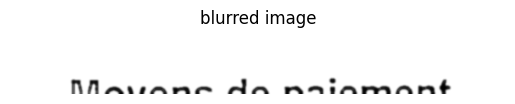

{'level': [1, 2, 3, 4, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 2, 3, 4, 5, 6], 'left': [0, 104, 104, 104, 104, 160, 368, 472, 565, 652], 'top': [0, 79, 79, 79, 81, 81, 80, 79, 92, 81], 'width': [838, 640, 640, 640, 45, 181, 69, 78, 73, 92], 'height': [105, 26, 26, 26, 24, 24, 25, 26, 13, 24], 'conf': [-1, -1, -1, -1, 1, 0, 79, 21, 0, 0], 'text': ['', '', '', '', 'Rh', 'arwcearmre', 'Aa', 'mas', 'Am', 'am']}
['Aa']
[79]
cell: 0 of size : 838x105
Has text: Aa with confidence: [79]
And coordinates: 14, 21
i = 0
Previous cells line coordinate is : 21
Current line coordinate is : 21
APPEND SAME LINE

[['Aa']]


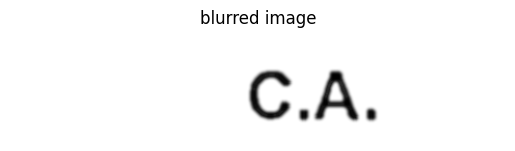

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 232, 232, 232, 232], 'top': [0, 38, 38, 38, 38], 'width': [479, 104, 104, 104, 104], 'height': [105, 47, 47, 47, 47], 'conf': [-1, -1, -1, -1, 90], 'text': ['', '', '', '', 'C.A']}
['C.A']
[90]
cell: 1 of size : 479x105
Has text: C.A with confidence: [90]
And coordinates: 859, 21
i = 1
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A']]


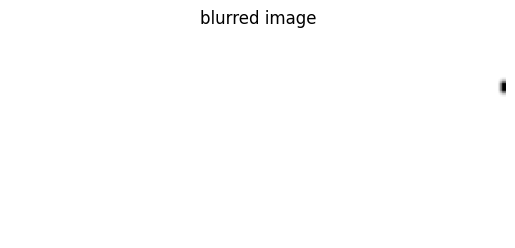

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [253], 'height': [105], 'conf': [-1], 'text': ['']}
[]
[]
cell: 2 of size : 253x105
Has text:  with confidence: []
And coordinates: 1348, 21
i = 2
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '']]


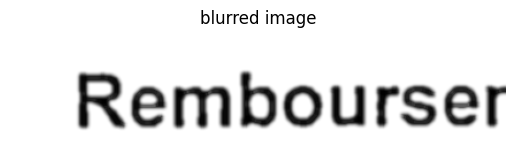

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 60, 60, 60, 60], 'top': [0, 35, 35, 35, 35], 'width': [431, 371, 371, 371, 371], 'height': [105, 48, 48, 48, 48], 'conf': [-1, -1, -1, -1, 92], 'text': ['', '', '', '', 'Rembourser']}
['Rembourser']
[92]
cell: 3 of size : 431x105
Has text: Rembourser with confidence: [92]
And coordinates: 1611, 21
i = 3
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser']]


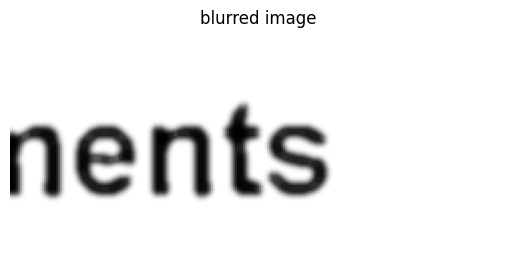

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 0, 0, 0, 0], 'top': [0, 37, 37, 37, 37], 'width': [247, 158, 158, 158, 158], 'height': [105, 45, 45, 45, 45], 'conf': [-1, -1, -1, -1, 95], 'text': ['', '', '', '', 'nents']}
['nents']
[95]
cell: 4 of size : 247x105
Has text: nents with confidence: [95]
And coordinates: 2049, 21
i = 4
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents']]


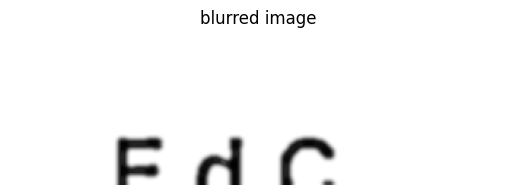

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 74, 74, 74, 74], 'top': [0, 73, 73, 73, 73], 'width': [340, 148, 148, 148, 148], 'height': [105, 32, 32, 32, 32], 'conf': [-1, -1, -1, -1, 28], 'text': ['', '', '', '', 'Cnt']}
[]
[]
cell: 5 of size : 340x105
Has text:  with confidence: []
And coordinates: 2306, 21
i = 5
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '']]


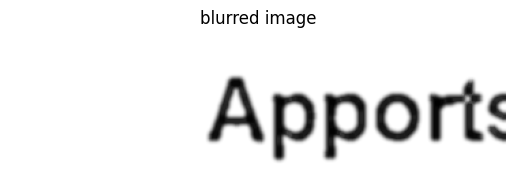

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 146, 146, 146, 146], 'top': [0, 34, 34, 34, 34], 'width': [364, 218, 218, 218, 218], 'height': [105, 60, 60, 60, 60], 'conf': [-1, -1, -1, -1, 90], 'text': ['', '', '', '', 'Apport:']}
['Apport:']
[90]
cell: 6 of size : 364x105
Has text: Apport: with confidence: [90]
And coordinates: 2656, 21
i = 6
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:']]


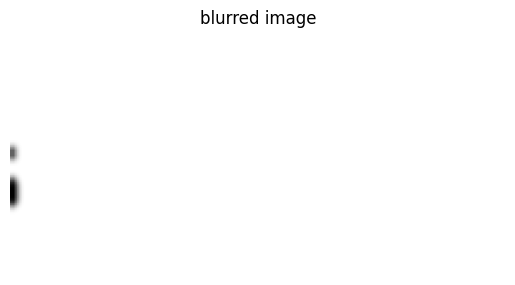

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [214], 'height': [105], 'conf': [-1], 'text': ['']}
[]
[]
cell: 7 of size : 214x105
Has text:  with confidence: []
And coordinates: 3032, 21
i = 7
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '']]


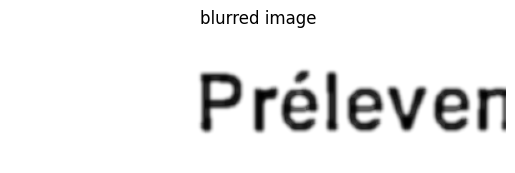

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 153, 153, 153, 153], 'top': [0, 32, 32, 32, 32], 'width': [397, 244, 244, 244, 244], 'height': [105, 48, 48, 48, 48], 'conf': [-1, -1, -1, -1, 90], 'text': ['', '', '', '', 'Prélever']}
['Prélever']
[90]
cell: 8 of size : 397x105
Has text: Prélever with confidence: [90]
And coordinates: 3253, 21
i = 8
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever']]


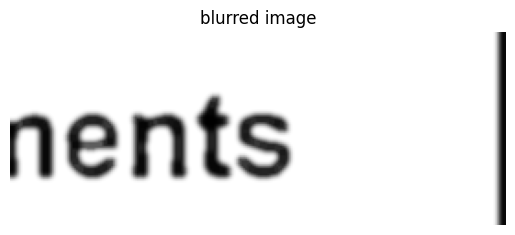

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 0, 0, 0, 0], 'top': [0, 35, 35, 35, 35], 'width': [270, 152, 152, 152, 152], 'height': [105, 44, 44, 44, 44], 'conf': [-1, -1, -1, -1, 95], 'text': ['', '', '', '', 'nents']}
['nents']
[95]
cell: 9 of size : 270x105
Has text: nents with confidence: [95]
And coordinates: 3651, 21
i = 9
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents']]


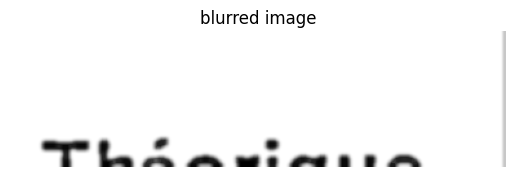

{'level': [1, 2, 3, 4, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 2, 3, 4, 5], 'left': [0, 25, 25, 25, 21, 108, 141, 185, 217], 'top': [0, 84, 84, 84, 80, 97, 96, 96, 96], 'width': [384, 293, 293, 293, 73, 13, 18, 22, 101], 'height': [105, 21, 21, 21, 25, 8, 9, 9, 9], 'conf': [-1, -1, -1, -1, 29, 29, 65, 19, 13], 'text': ['', '', '', '', 'ere.', '©', '.', '*', 'asa']}
['.']
[65]
cell: 10 of size : 384x105
Has text: . with confidence: [65]
And coordinates: 3924, 21
i = 10
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.']]


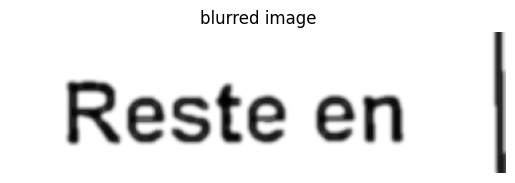

{'level': [1, 2, 3, 4, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 2], 'left': [0, 43, 43, 43, 43, 229], 'top': [0, 37, 37, 37, 37, 48], 'width': [370, 250, 250, 250, 162, 64], 'height': [105, 46, 46, 46, 46, 34], 'conf': [-1, -1, -1, -1, 92, 96], 'text': ['', '', '', '', 'Reste', 'en']}
['Reste', 'en']
[92, 96]
cell: 11 of size : 370x105
Has text: Reste en with confidence: [92, 96]
And coordinates: 4313, 21
i = 11
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en']]


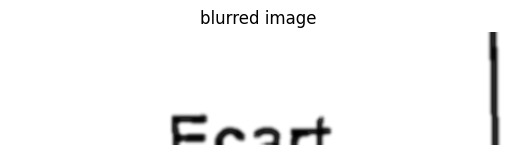

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 150, 150, 150, 150], 'top': [0, 77, 77, 77, 77], 'width': [459, 147, 147, 147, 147], 'height': [105, 28, 28, 28, 28], 'conf': [-1, -1, -1, -1, 34], 'text': ['', '', '', '', 'Caanrt']}
['Caanrt']
[34]
cell: 12 of size : 459x105
Has text: Caanrt with confidence: [34]
And coordinates: 4690, 21
i = 12
Previous cells line coordinate is : 1076
Current line coordinate is : 21
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt']]


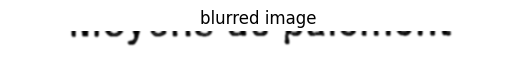

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4], 'par_num': [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 3, 4], 'left': [0, 710, 710, 710, 710, 730, 730, 730, 730, 161, 161, 161, 161, 220, 297, 297, 297, 297, 370, 464, 559], 'top': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'width': [838, 8, 8, 8, 8, 15, 15, 15, 15, 103, 103, 103, 30, 44, 381, 381, 381, 44, 65, 67, 119], 'height': [67, 8, 8, 8, 8, 8, 8, 8, 8, 23, 23, 23, 9, 27, 22, 22, 22, 9, 8, 22, 8], 'conf': [-1, -1, -1, -1, 56, -1, -1, -1, 69, -1, -1, -1, 32, 28, -1, -1, -1, 77, 0, 35, 40], 'text': ['', '', '', '', 'ad', '', '', '', '=', '', '', '', 'i', 'Sit', '', '',

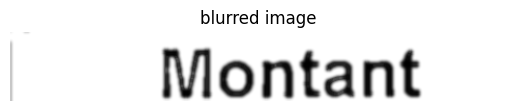

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 148, 148, 148, 148], 'top': [0, 17, 17, 17, 17], 'width': [479, 248, 248, 248, 248], 'height': [67, 47, 47, 47, 47], 'conf': [-1, -1, -1, -1, 84], 'text': ['', '', '', '', 'Viontant']}
['Viontant']
[84]
cell: 14 of size : 479x67
Has text: Viontant with confidence: [84]
And coordinates: 859, 139
i = 14
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant']]


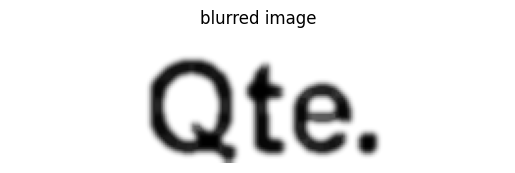

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 72, 72, 72, 72], 'top': [0, 15, 15, 15, 15], 'width': [253, 102, 102, 102, 102], 'height': [67, 52, 52, 52, 52], 'conf': [-1, -1, -1, -1, 91], 'text': ['', '', '', '', 'Qte']}
['Qte']
[91]
cell: 15 of size : 253x67
Has text: Qte with confidence: [91]
And coordinates: 1348, 139
i = 15
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte']]


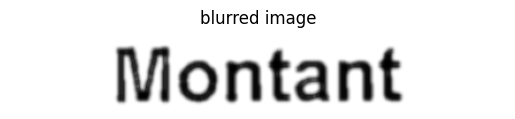

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 93, 93, 93, 93], 'top': [0, 14, 14, 14, 14], 'width': [431, 247, 247, 247, 247], 'height': [67, 47, 47, 47, 47], 'conf': [-1, -1, -1, -1, 89], 'text': ['', '', '', '', 'Viontant']}
['Viontant']
[89]
cell: 16 of size : 431x67
Has text: Viontant with confidence: [89]
And coordinates: 1611, 139
i = 16
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant']]


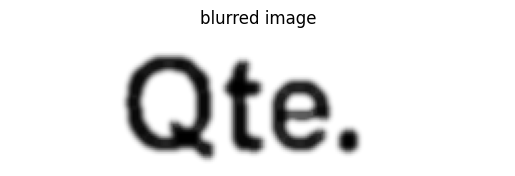

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 58, 58, 58, 58], 'top': [0, 13, 13, 13, 13], 'width': [247, 101, 101, 101, 101], 'height': [67, 50, 50, 50, 50], 'conf': [-1, -1, -1, -1, 91], 'text': ['', '', '', '', 'Qte']}
['Qte']
[91]
cell: 17 of size : 247x67
Has text: Qte with confidence: [91]
And coordinates: 2049, 139
i = 17
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte']]


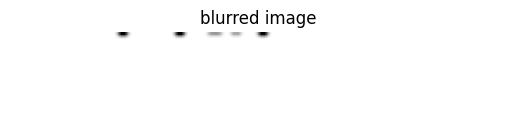

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [340], 'height': [67], 'conf': [-1], 'text': ['']}
[]
[]
cell: 18 of size : 340x67
Has text:  with confidence: []
And coordinates: 2306, 139
i = 18
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '']]


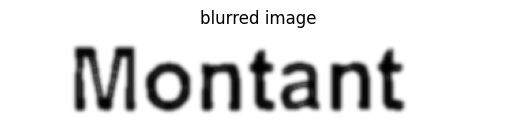

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 48, 48, 48, 48], 'top': [0, 12, 12, 12, 12], 'width': [364, 241, 241, 241, 241], 'height': [67, 46, 46, 46, 46], 'conf': [-1, -1, -1, -1, 83], 'text': ['', '', '', '', 'Viontant']}
['Viontant']
[83]
cell: 19 of size : 364x67
Has text: Viontant with confidence: [83]
And coordinates: 2656, 139
i = 19
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant']]


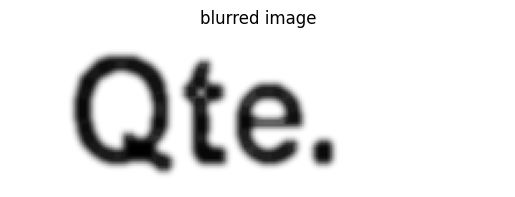

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 28, 28, 28, 28], 'top': [0, 11, 11, 11, 11], 'width': [214, 98, 98, 98, 98], 'height': [67, 49, 49, 49, 49], 'conf': [-1, -1, -1, -1, 90], 'text': ['', '', '', '', 'Qte']}
['Qte']
[90]
cell: 20 of size : 214x67
Has text: Qte with confidence: [90]
And coordinates: 3032, 139
i = 20
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte']]


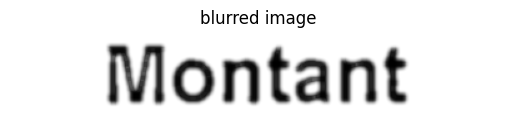

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 79, 79, 79, 79], 'top': [0, 11, 11, 11, 11], 'width': [397, 238, 238, 238, 238], 'height': [67, 46, 46, 46, 46], 'conf': [-1, -1, -1, -1, 47], 'text': ['', '', '', '', 'Viontant']}
['Viontant']
[47]
cell: 21 of size : 397x67
Has text: Viontant with confidence: [47]
And coordinates: 3253, 139
i = 21
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant']]


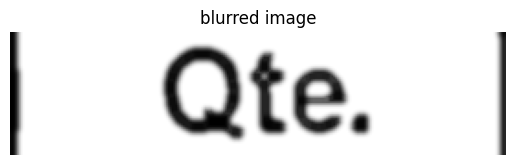

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 84, 84, 84, 84], 'top': [0, 9, 9, 9, 9], 'width': [270, 111, 111, 111, 111], 'height': [67, 49, 49, 49, 49], 'conf': [-1, -1, -1, -1, 91], 'text': ['', '', '', '', 'Qte.']}
['Qte.']
[91]
cell: 22 of size : 270x67
Has text: Qte. with confidence: [91]
And coordinates: 3651, 139
i = 22
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.']]


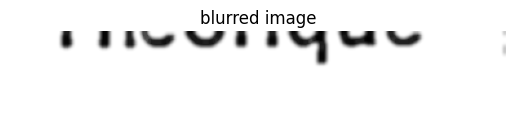

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], 'par_num': [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], 'left': [0, 40, 40, 40, 40, 69, 69, 69, 69, 199, 199, 199, 199], 'top': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'width': [384, 8, 8, 8, 8, 28, 28, 28, 28, 119, 119, 119, 119], 'height': [67, 13, 13, 13, 13, 13, 13, 13, 13, 29, 29, 29, 29], 'conf': [-1, -1, -1, -1, 21, -1, -1, -1, 76, -1, -1, -1, 0], 'text': ['', '', '', '', '.', '', '', '', 'es', '', '', '', '—__~—']}
['es']
[76]
cell: 23 of size : 384x67
Has text: es with confidence: [76]
And coordinates: 3924, 139
i = 23
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad

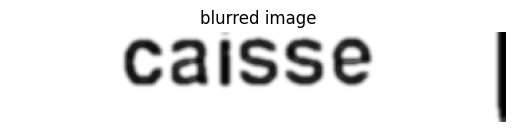

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 86, 86, 86, 86], 'top': [0, 5, 5, 5, 5], 'width': [370, 183, 183, 183, 183], 'height': [67, 35, 35, 35, 35], 'conf': [-1, -1, -1, -1, 87], 'text': ['', '', '', '', 'caisse']}
['caisse']
[87]
cell: 24 of size : 370x67
Has text: caisse with confidence: [87]
And coordinates: 4313, 139
i = 24
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse']]


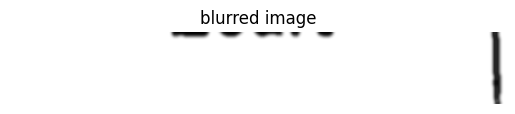

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [459], 'height': [67], 'conf': [-1], 'text': ['']}
[]
[]
cell: 25 of size : 459x67
Has text:  with confidence: []
And coordinates: 4690, 139
i = 25
Previous cells line coordinate is : 989
Current line coordinate is : 139
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', '']]


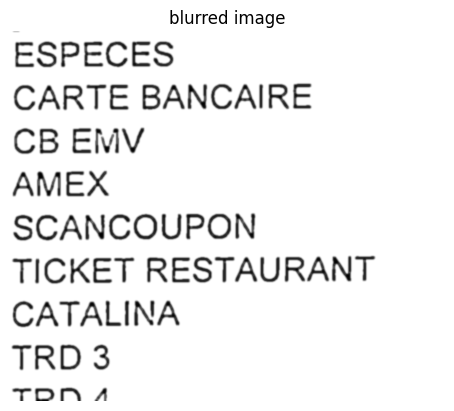

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9], 'par_num': [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2], 'left': [0, 10, 10, 10, 10, 8, 8, 8, 8, 255, 8, 8, 8, 8, 120, 5, 5, 5, 5, 7, 7, 7, 7, 5, 5, 5, 5, 264, 5, 5, 5, 5, 4, 4, 4, 4, 162, 5, 5, 5, 5, 164], 'top': [0, 2

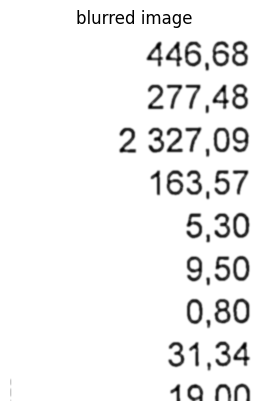

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 9], 'par_num': [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2], 'left': [0, 263, 263, 263, 263, 266, 266, 266, 266, 211, 211, 211, 211, 267, 271, 271, 271, 271, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 305, 305, 305, 305, 309, 309, 309, 309, 394], 'top': [0, 19

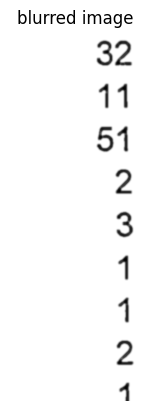

{'level': [1, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4], 'par_num': [0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], 'left': [0, 167, 167, 167, 167, 171, 171, 171, 171, 167, 167, 167, 167, 205, 205, 205, 205], 'top': [0, 18, 18, 18, 18, 102, 102, 102, 102, 184, 184, 184, 184, 349, 349, 349, 349], 'width': [253, 66, 66, 66, 66, 55, 55, 55, 55, 59, 59, 59, 59, 27, 31, 27, 27], 'height': [713, 49, 49, 49, 49, 46, 46, 46, 46, 49, 49, 49, 49, 364, 364, 364, 364], 'conf': [-1, -1, -1, -1, 96, -1, -1, -1, 96, -1, -1, -1, 83, -1, -1, -1, 24], 'text': ['', '', '', '', '32', '', '', '', '11', '', '', '', '51', '', '', '', '3']}
['32', '11', '51']
[96, 96, 83]
cell: 28 of size : 253x713
Has text: 32 11 51 with confidence: [96, 96,

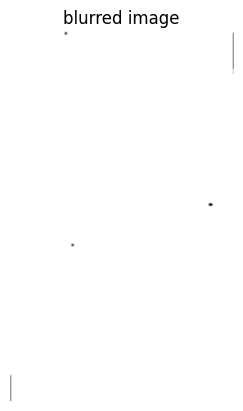

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [431], 'height': [713], 'conf': [-1], 'text': ['']}
[]
[]
cell: 29 of size : 431x713
Has text:  with confidence: []
And coordinates: 1611, 233
i = 29
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '']]


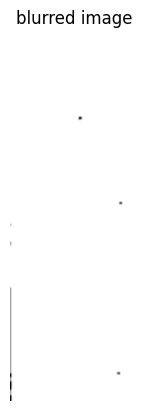

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [247], 'height': [713], 'conf': [-1], 'text': ['']}
[]
[]
cell: 30 of size : 247x713
Has text:  with confidence: []
And coordinates: 2049, 233
i = 30
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '']]


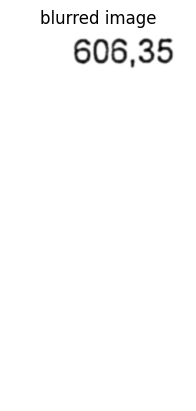

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 123, 123, 123, 123], 'top': [0, 14, 14, 14, 14], 'width': [340, 190, 190, 190, 190], 'height': [713, 56, 56, 56, 56], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '606,35']}
['606,35']
[96]
cell: 31 of size : 340x713
Has text: 606,35 with confidence: [96]
And coordinates: 2306, 233
i = 31
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35']]


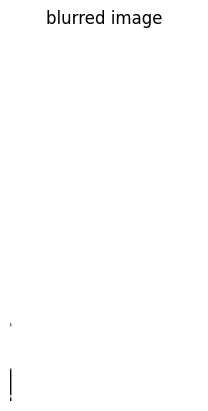

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [364], 'height': [713], 'conf': [-1], 'text': ['']}
[]
[]
cell: 32 of size : 364x713
Has text:  with confidence: []
And coordinates: 2656, 233
i = 32
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '']]


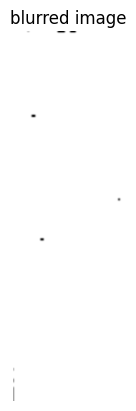

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [214], 'height': [713], 'conf': [-1], 'text': ['']}
[]
[]
cell: 33 of size : 214x713
Has text:  with confidence: []
And coordinates: 3032, 233
i = 33
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '']]


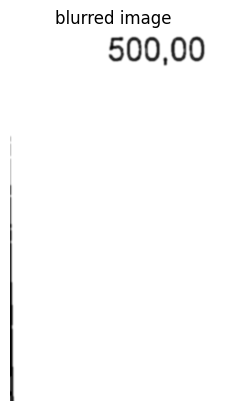

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 191, 191, 191, 191], 'top': [0, 11, 11, 11, 11], 'width': [397, 183, 183, 183, 183], 'height': [713, 55, 55, 55, 55], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '500,00']}
['500,00']
[96]
cell: 34 of size : 397x713
Has text: 500,00 with confidence: [96]
And coordinates: 3253, 233
i = 34
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00']]

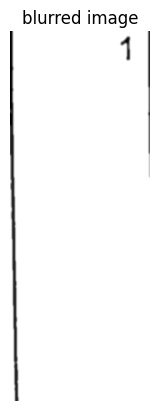

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [270], 'height': [713], 'conf': [-1], 'text': ['']}
[]
[]
cell: 35 of size : 270x713
Has text:  with confidence: []
And coordinates: 3651, 233
i = 35
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '']]


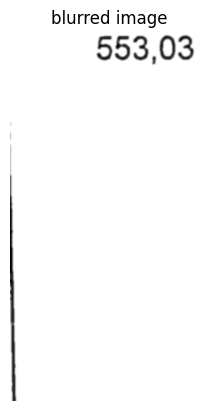

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 167, 167, 167, 167], 'top': [0, 8, 8, 8, 8], 'width': [384, 186, 186, 186, 186], 'height': [713, 56, 56, 56, 56], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '553,03']}
['553,03']
[96]
cell: 36 of size : 384x713
Has text: 553,03 with confidence: [96]
And coordinates: 3924, 233
i = 36
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', 

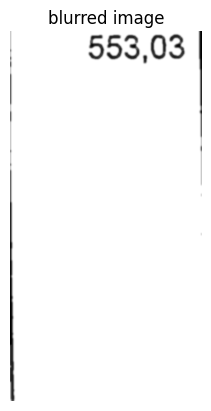

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 152, 152, 152, 152], 'top': [0, 7, 7, 7, 7], 'width': [370, 184, 184, 184, 184], 'height': [713, 55, 55, 55, 55], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '553,03']}
['553,03']
[96]
cell: 37 of size : 370x713
Has text: 553,03 with confidence: [96]
And coordinates: 4313, 233
i = 37
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', 

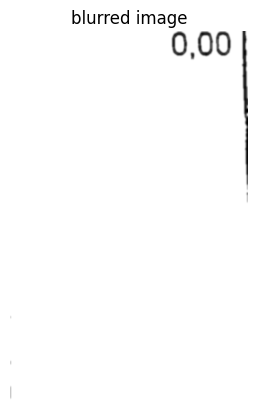

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 312, 312, 312, 312], 'top': [0, 1, 1, 1, 1], 'width': [459, 114, 114, 114, 114], 'height': [713, 47, 47, 47, 47], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '0,00']}
['0,00']
[96]
cell: 38 of size : 459x713
Has text: 0,00 with confidence: [96]
And coordinates: 4690, 233
i = 38
Previous cells line coordinate is : 233
Current line coordinate is : 233
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,0

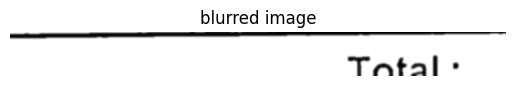

{'level': [1, 2, 3, 4, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 2], 'left': [0, 571, 571, 571, 571, 749], 'top': [0, 41, 41, 41, 41, 53], 'width': [838, 187, 187, 187, 151, 9], 'height': [75, 34, 34, 34, 34, 10], 'conf': [-1, -1, -1, -1, 51, 24], 'text': ['', '', '', '', 'Tratal', '-']}
['Tratal']
[51]
cell: 39 of size : 838x75
Has text: Tratal with confidence: [51]
And coordinates: 14, 989
i = 39
Previous cells line coordinate is : 233
Current line coordinate is : 989
APPEND NEW LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51'

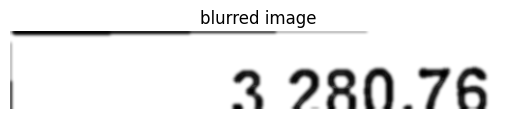

{'level': [1, 2, 3, 4, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1, 1], 'word_num': [0, 0, 0, 0, 1, 2], 'left': [0, 215, 215, 215, 215, 398], 'top': [0, 35, 35, 35, 38, 35], 'width': [479, 245, 245, 245, 155, 62], 'height': [75, 40, 40, 40, 37, 40], 'conf': [-1, -1, -1, -1, 41, 90], 'text': ['', '', '', '', '2920', '76']}
['2920', '76']
[41, 90]
cell: 40 of size : 479x75
Has text: 2920 76 with confidence: [41, 90]
And coordinates: 859, 989
i = 40
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 

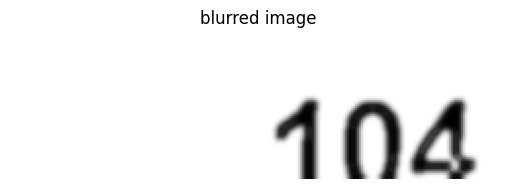

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 136, 136, 136, 136], 'top': [0, 35, 35, 35, 35], 'width': [253, 101, 101, 101, 101], 'height': [75, 40, 40, 40, 40], 'conf': [-1, -1, -1, -1, 62], 'text': ['', '', '', '', '1NA']}
['1NA']
[62]
cell: 41 of size : 253x75
Has text: 1NA with confidence: [62]
And coordinates: 1348, 989
i = 41
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03

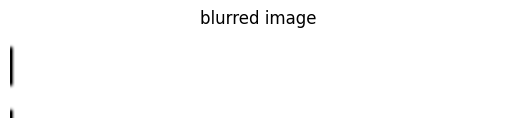

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [431], 'height': [75], 'conf': [-1], 'text': ['']}
[]
[]
cell: 42 of size : 431x75
Has text:  with confidence: []
And coordinates: 1611, 989
i = 42
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '']]


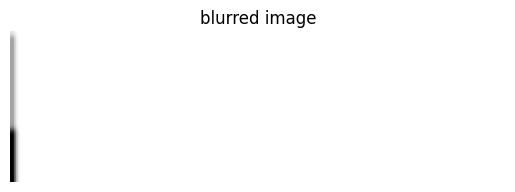

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [247], 'height': [75], 'conf': [-1], 'text': ['']}
[]
[]
cell: 43 of size : 247x75
Has text:  with confidence: []
And coordinates: 2049, 989
i = 43
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '']]


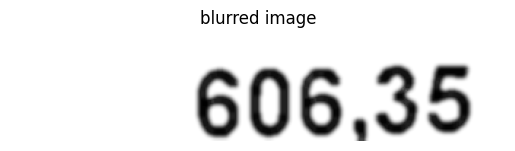

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 129, 129, 129, 129], 'top': [0, 24, 24, 24, 24], 'width': [340, 186, 186, 186, 186], 'height': [75, 51, 51, 51, 51], 'conf': [-1, -1, -1, -1, 87], 'text': ['', '', '', '', '606.35']}
['606.35']
[87]
cell: 44 of size : 340x75
Has text: 606.35 with confidence: [87]
And coordinates: 2306, 989
i = 44
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', ''

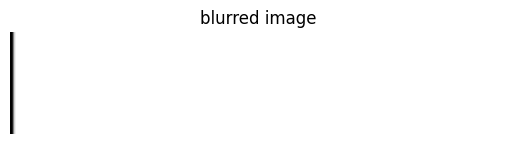

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [364], 'height': [75], 'conf': [-1], 'text': ['']}
[]
[]
cell: 45 of size : 364x75
Has text:  with confidence: []
And coordinates: 2656, 989
i = 45
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '']]


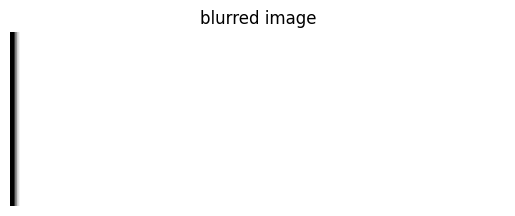

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [214], 'height': [75], 'conf': [-1], 'text': ['']}
[]
[]
cell: 46 of size : 214x75
Has text:  with confidence: []
And coordinates: 3032, 989
i = 46
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '']]


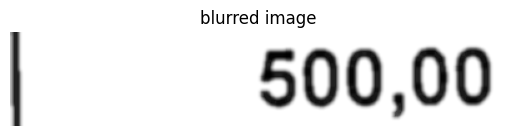

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 201, 201, 201, 201], 'top': [0, 13, 13, 13, 13], 'width': [397, 183, 183, 183, 183], 'height': [75, 55, 55, 55, 55], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '500,00']}
['500,00']
[96]
cell: 47 of size : 397x75
Has text: 500,00 with confidence: [96]
And coordinates: 3253, 989
i = 47
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', ''

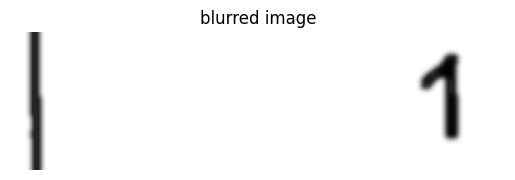

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [270], 'height': [75], 'conf': [-1], 'text': ['']}
[]
[]
cell: 48 of size : 270x75
Has text:  with confidence: []
And coordinates: 3651, 989
i = 48
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '']]


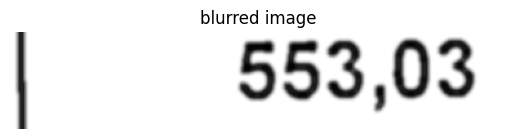

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 178, 178, 178, 178], 'top': [0, 6, 6, 6, 6], 'width': [384, 181, 181, 181, 181], 'height': [75, 55, 55, 55, 55], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '553,03']}
['553,03']
[96]
cell: 49 of size : 384x75
Has text: 553,03 with confidence: [96]
And coordinates: 3924, 989
i = 49
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '5

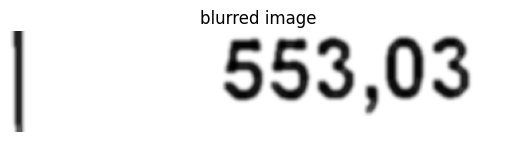

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 160, 160, 160, 160], 'top': [0, 5, 5, 5, 5], 'width': [370, 182, 182, 182, 182], 'height': [75, 56, 56, 56, 56], 'conf': [-1, -1, -1, -1, 96], 'text': ['', '', '', '', '553,03']}
['553,03']
[96]
cell: 50 of size : 370x75
Has text: 553,03 with confidence: [96]
And coordinates: 4313, 989
i = 50
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '5

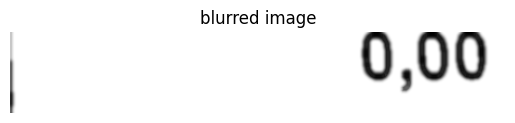

{'level': [1, 2, 3, 4, 5], 'page_num': [1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1], 'line_num': [0, 0, 0, 1, 1], 'word_num': [0, 0, 0, 0, 1], 'left': [0, 326, 326, 326, 326], 'top': [0, 0, 0, 0, 0], 'width': [459, 114, 114, 114, 114], 'height': [75, 55, 55, 55, 55], 'conf': [-1, -1, -1, -1, 3], 'text': ['', '', '', '', 'Q,00']}
[]
[]
cell: 51 of size : 459x75
Has text:  with confidence: []
And coordinates: 4690, 989
i = 51
Previous cells line coordinate is : 139
Current line coordinate is : 989
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,

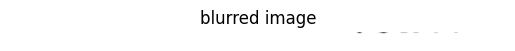

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [838], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 52 of size : 838x16
Has text:  with confidence: []
And coordinates: 14, 1076
i = 52
Previous cells line coordinate is : 139
Current line coordinate is : 1076
APPEND NEW LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['']]


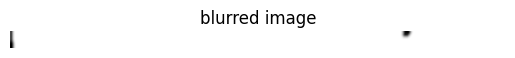

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [479], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 53 of size : 479x16
Has text:  with confidence: []
And coordinates: 859, 1076
i = 53
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '']]


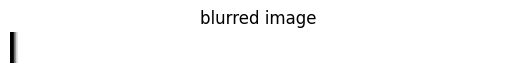

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [253], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 54 of size : 253x16
Has text:  with confidence: []
And coordinates: 1348, 1076
i = 54
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '']]


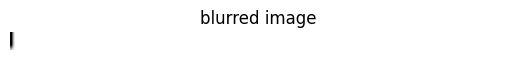

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [431], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 55 of size : 431x16
Has text:  with confidence: []
And coordinates: 1611, 1076
i = 55
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '']]


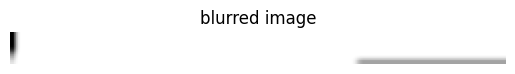

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [247], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 56 of size : 247x16
Has text:  with confidence: []
And coordinates: 2049, 1076
i = 56
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '']]


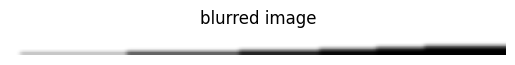

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [340], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 57 of size : 340x16
Has text:  with confidence: []
And coordinates: 2306, 1076
i = 57
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '']]


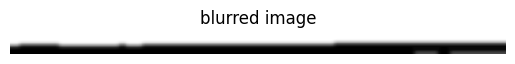

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [364], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 58 of size : 364x16
Has text:  with confidence: []
And coordinates: 2656, 1076
i = 58
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '', '']]


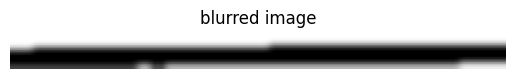

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [214], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 59 of size : 214x16
Has text:  with confidence: []
And coordinates: 3032, 1076
i = 59
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '', '', '']]


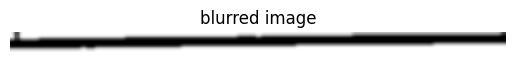

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [397], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 60 of size : 397x16
Has text:  with confidence: []
And coordinates: 3253, 1076
i = 60
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '', '', '', '']]


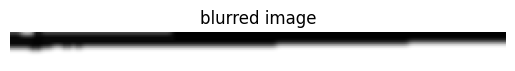

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [270], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 61 of size : 270x16
Has text:  with confidence: []
And coordinates: 3651, 1076
i = 61
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '', '', '', '', '']]


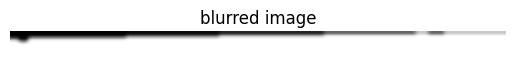

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [384], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 62 of size : 384x16
Has text:  with confidence: []
And coordinates: 3924, 1076
i = 62
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '', '', '', '', '', '']]


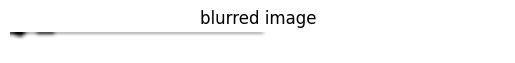

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [370], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 63 of size : 370x16
Has text:  with confidence: []
And coordinates: 4313, 1076
i = 63
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '', '', '', '', '', '', '']]


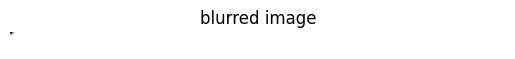

{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [459], 'height': [16], 'conf': [-1], 'text': ['']}
[]
[]
cell: 64 of size : 459x16
Has text:  with confidence: []
And coordinates: 4690, 1076
i = 64
Previous cells line coordinate is : 21
Current line coordinate is : 1076
APPEND SAME LINE

[['Aa', 'C.A', '', 'Rembourser', 'nents', '', 'Apport:', '', 'Prélever', 'nents', '.', 'Reste en', 'Caanrt'], ['ad = i — oa ee', 'Viontant', 'Qte', 'Viontant', 'Qte', '', 'Viontant', 'Qte', 'Viontant', 'Qte.', 'es', 'caisse', ''], ['ESPECES CARTE BANCAIRE CB EMV AMEX SCANCOUPON TICKET RESTAURANT CATALINA TRD 3 Tor A', '446,68 277,48 2 327,09 163,57 5,30 9,50 0,80 31,34 40', '32 11 51', '', '', '606,35', '', '', '500,00', '', '553,03', '553,03', '0,00'], ['Tratal', '2920 76', '1NA', '', '', '606.35', '', '', '500,00', '', '553,03', '553,03', ''], ['', '', '', '', '', '', '', '', '', '', '', '', '']]
[['Aa', 'C.A', '', '

In [39]:
csv = makeCsv(imgPath, preprocessed_img, cells)